<a href="https://colab.research.google.com/github/sebasesto/CEIA/blob/master/VpC2/Clase_2_Tarea_con_DataAugmentation_Sesto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilizando el dataset de señas de manos, crear una red neuronal con caracteristicas similares a las vistas en clase y entrenarla hasta obtener un accuracy de, como minimo, 85% evitando sobreentrenamiento. Aplicar las técnicas de data augmentation que consideren necesarias.

---
El dataset es un conjunto de imagenes de una mano realizando figuras de numeros del 0 al 5. El objetivo es clasificar a que digito corresponde cada imagen.

<img src="https://drive.google.com/uc?export=view&id=1Tm9arSkvypYpXzANQo4C2DtMWzkjA4hO" style="width:800px;height:300px;">

Para cargar en memoria el dataset suministrado pueden utilizar la siguiente función:


In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:])
    train_y = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_signs.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:])
    test_y = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

In [2]:
# https://drive.google.com/file/d/1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-/view?usp=sharing
# El ID sera: 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
# !gdown --id 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-  #Dataset de la clase

# https://drive.google.com/file/d/1-VxyI9TT2k5u8grHhrJtivvIIf2A4Ujt/view?usp=sharing
!gdown --id 1-VxyI9TT2k5u8grHhrJtivvIIf2A4Ujt # Dataset copiado a mi propio drive

Downloading...
From: https://drive.google.com/uc?id=1-VxyI9TT2k5u8grHhrJtivvIIf2A4Ujt
To: /content/dataset_manos.rar
100% 7.23M/7.23M [00:00<00:00, 63.7MB/s]


In [3]:
!unrar x /content/dataset_manos.rar > /dev/null

In [18]:
train_x, train_Y, test_x, test_Y, classes = load_dataset()

El conjunto de entrenamiento tiene 1080 imágenes
El conjunto de testeo tiene 120 imágenes
Las imágenes son de: (64, 64, 3)
Label de la imágen 0: 5
Label de la imágen 1: 0
Label de la imágen 2: 2
Label de la imágen 3: 5
Label de la imágen 4: 2
Label de la imágen 5: 4
Label de la imágen 6: 2
Label de la imágen 7: 1
Label de la imágen 8: 1


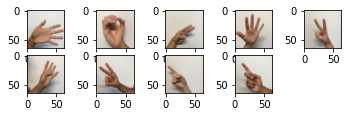

In [19]:
print("El conjunto de entrenamiento tiene {} imágenes".format(len(train_x)))
print("El conjunto de testeo tiene {} imágenes".format(len(test_x)))
print("Las imágenes son de: {}".format(train_x[0].shape))

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):

  plt.subplot(551 + i)
  plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, train_Y[0, i]))

plt.show()

In [20]:
print("Dimensiones de la salida:", train_Y.shape)
print("Dimensiones de las entradas:", train_x.shape)

Dimensiones de la salida: (1, 1080)
Dimensiones de las entradas: (1080, 64, 64, 3)


Readaptamos las etiquetas para que queden en formato one-hot.

In [21]:
train_y = tf.one_hot(train_Y[0], 6)
test_y = tf.one_hot(test_Y[0], 6)
print("Dimensiones con OHE",train_y.shape)

Dimensiones con OHE (1080, 6)


Dado que las imágenes contienen pixeles con valores en el rango de 0 a 255, realizamos una normalización para llevarlas al rango 0 a 1.

Despues crear el set de validacion

In [22]:
from imgaug import augmenters as iaa

aug1 = iaa.GaussianBlur(sigma=(0, 2.0))
aug2 = iaa.AdditiveGaussianNoise(scale=0.02 * 255)

# Defino una función que aplica las transformaciones sobre una imágen
def additional_augmentation(image):
    image = aug1.augment_image(image)
    image = aug2.augment_image(image)
    return image

In [23]:
# Definir las dimensiones para usar en el modelo:
width, height, channels = train_x[0].shape

In [24]:
valid_x = train_x[:120]
valid_y = train_y[:120]

train_datagen = ImageDataGenerator(width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       brightness_range=[0.6, 1.2],
                                       zoom_range=[0.5, 1.5],
                                       horizontal_flip=True,
                                       rescale=1./255,
                                       preprocessing_function=additional_augmentation)

test_datagen = ImageDataGenerator(width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       brightness_range=[0.6, 1.2],
                                       zoom_range=[0.5, 1.5],
                                       horizontal_flip=True,
                                       rescale=1./255,
                                       preprocessing_function=additional_augmentation)
valid_datagen = ImageDataGenerator(width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       brightness_range=[0.6, 1.2],
                                       zoom_range=[0.5, 1.5],
                                       horizontal_flip=True,
                                       rescale=1./255,
                                       preprocessing_function=additional_augmentation)

# print("Dimensiones de la salida:", train_y.shape)
# print("Dimensiones de las entradas:", train_x.shape)
# print("Dimensiones de la salida:", test_y.shape)
# print("Dimensiones de las entradas:", test_x.shape)
train_generator = train_datagen.flow(train_x, train_y, batch_size=32)#,subset='training')
test_generator = test_datagen.flow(test_x, test_y, batch_size=32)#,subset='validation')
test_generator = valid_datagen.flow(valid_x, valid_y, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


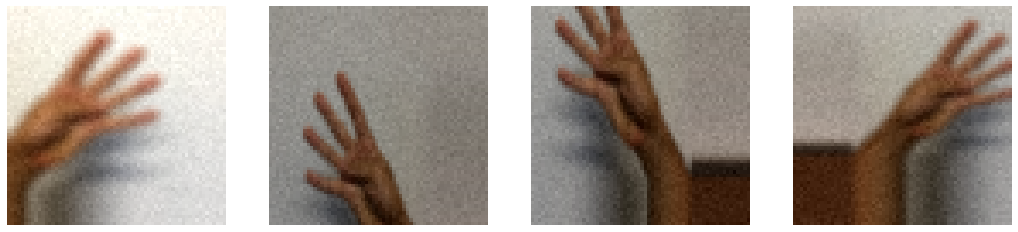

In [25]:
#plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
image = train_x[30]#plt.imread("train/cats/cat.106.jpg")
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
test_train_generator = train_datagen.flow(image)

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(test_train_generator.next()[0])
    row.axis('off')
plt.show()

In [26]:
model = tf.keras.Sequential()

#model.add(tf.keras.layers.Input(shape=(64, 64, 3)))## SHAPE DE IMAGENES
model.add(tf.keras.layers.Input(shape=(width, height, channels)))## SHAPE DE IMAGENES
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Flatten())# Convertir a vector unidimensional.
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)        

In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),# la otra opcion es SDG
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [28]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=test_generator)
# history = model.fit(x=train_x, 
#                     y=train_y,
#                     #batch_size=64
#                     epochs=30,
#                     validation_data=(test_x,test_y))

Epoch 1/30
34/34 [==============================] - 12s 313ms/step - loss: 1.8123 - categorical_accuracy: 0.1574 - val_loss: 1.7977 - val_categorical_accuracy: 0.1833
Epoch 2/30
34/34 [==============================] - 10s 302ms/step - loss: 1.7925 - categorical_accuracy: 0.1704 - val_loss: 1.7891 - val_categorical_accuracy: 0.1583
Epoch 3/30
34/34 [==============================] - 10s 301ms/step - loss: 1.7892 - categorical_accuracy: 0.2046 - val_loss: 1.7588 - val_categorical_accuracy: 0.2167
Epoch 4/30
34/34 [==============================] - 10s 300ms/step - loss: 1.7583 - categorical_accuracy: 0.2176 - val_loss: 1.7064 - val_categorical_accuracy: 0.2750
Epoch 5/30
34/34 [==============================] - 10s 299ms/step - loss: 1.7141 - categorical_accuracy: 0.2565 - val_loss: 1.6573 - val_categorical_accuracy: 0.3250
Epoch 6/30
34/34 [==============================] - 10s 301ms/step - loss: 1.6276 - categorical_accuracy: 0.3352 - val_loss: 1.5350 - val_categorical_accuracy: 0.375

## Visualización de los resultados

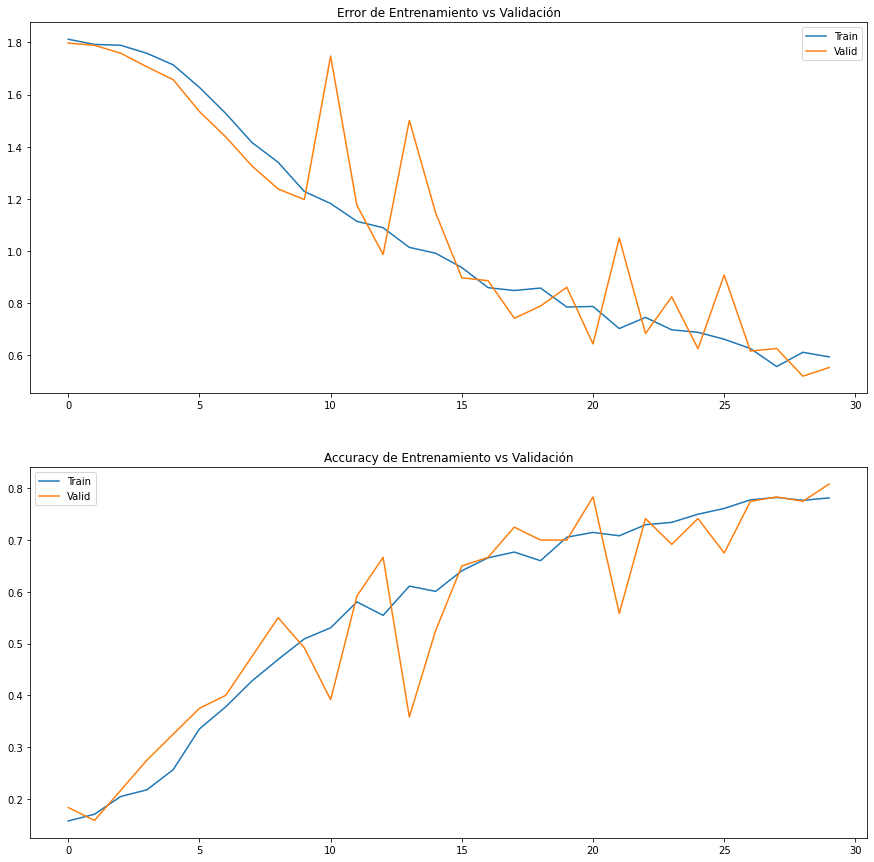

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss']) 
axs[0].plot(history.history['val_loss']) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history.history['categorical_accuracy']) 
axs[1].plot(history.history['val_categorical_accuracy']) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

## Evaluación del modelo

Una vez entrenado el modelo, podemos evaluarlo con el conjunto de test mediante la funcion `evaluate`.

In [32]:
results = model.evaluate(valid_x, valid_y)

print("El modelo logro un error de {} y una accuracy de {}".format(results[0], results[1]))

4/4 [==============================] - 0s 51ms/step - loss: 29.6913 - categorical_accuracy: 0.8833
El modelo logro un error de 29.691316604614258 y una accuracy de 0.8833333253860474
